In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
storage_delay = 30
pay_delay = 60
self_price = 1
sell_price = 2
discont_price = 1.5
min_pay = 10
storage_pay = 0.1

In [3]:
df = pd.read_csv('data.csv', sep=';')
df.drop(['День п/п', 'Unnamed: 7', 'Дней пр.'], axis=1, inplace = True)
df.set_index('Дата', inplace = True)
df.drop('Склад', inplace = True)
df.index = pd.to_datetime(df.index, format='%d.%m.%Y')
df.fillna(0, inplace = True)
opt_df = df.copy()

In [4]:
df['long_storage'] = 0
for i in tqdm(range(1079)):
    df.loc[df.index[i+storage_delay:],'long_storage'] += df.loc[df.index[i], 'Приход']
    df.loc[df.index[i:],'long_storage'] -= df.loc[df.index[i], 'Расход']

In [5]:
df['long_storage'] = np.maximum(df['long_storage'], 0)
df['storage_cost'] = storage_pay * df['long_storage']
df['storage_cost'] += min_pay*(df['Приход']>0)
df['total_cost'] = np.cumsum(df['storage_cost'])
t = ((sell_price-self_price)*np.array(df['На складе']>0) 
     + (discont_price-self_price)*np.array(df['На складе']<0))
df['total_profit'] = np.cumsum(t*df['Расход']) - df['total_cost']

In [6]:
df.head()

,д.н.,Приход,Расход,На складе,long_storage,storage_cost,total_cost,total_profit
Дата,,,,,,,,
2016-01-12,3.0,0.0,0.0,52,0.0,0.0,0.0,0.0
2016-01-13,4.0,0.0,0.0,52,0.0,0.0,0.0,0.0
2016-01-14,5.0,0.0,0.0,52,0.0,0.0,0.0,0.0
2016-01-15,6.0,0.0,0.0,52,0.0,0.0,0.0,0.0
2016-01-16,7.0,0.0,0.0,52,0.0,0.0,0.0,0.0


In [7]:
opt_df['long_storage'] = 0
opt_df.loc[1:,'На складе'] = 0
opt_df['Приход'] = 0
opt_df['r_mean'] = 1.5*(opt_df['Расход'].rolling(window=30).mean() - opt_df['Расход'].rolling(window=30).max()/30)
wait = False
for i in tqdm(range(1079)):
    try:
        opt_df.loc[opt_df.index[i], 'На складе'] += opt_df.loc[opt_df.index[i], 'Приход'] 
        wait = wait and opt_df.loc[opt_df.index[i], 'Приход'] == 0
        opt_df.loc[opt_df.index[i+1], 'На складе'] = opt_df.loc[opt_df.index[i], 'На складе'] - opt_df.loc[opt_df.index[i], 'Расход']
        if opt_df.loc[opt_df.index[i], 'На складе'] < opt_df.loc[opt_df.index[i], 'r_mean'] and not wait:
            opt_df.loc[opt_df.index[i+storage_delay], 'Приход'] =  opt_df.loc[opt_df.index[i], 'r_mean']*(storage_delay + 5)
            if opt_df.loc[opt_df.index[i], 'На складе'] < 0:
                opt_df.loc[opt_df.index[i+storage_delay], 'Приход'] -= opt_df.loc[opt_df.index[i], 'На складе']
            wait = True
    except:
        pass
    
for i in tqdm(range(1079)):    
    opt_df.loc[opt_df.index[i+pay_delay:],'long_storage'] += opt_df.loc[opt_df.index[i], 'Приход']
    opt_df.loc[opt_df.index[i:], 'long_storage'] -= opt_df.loc[opt_df.index[i], 'Расход']

In [8]:
opt_df['storage_cost'] = storage_pay * opt_df['long_storage']
opt_df['storage_cost'] += min_pay*(opt_df['Приход']>0)
opt_df['total_cost'] = np.cumsum(opt_df['storage_cost'])
t = ((sell_price-self_price)*np.array(opt_df['На складе']>0) 
     + (discont_price-self_price)*np.array(opt_df['На складе']<0))
opt_df['total_profit'] = np.cumsum(t*opt_df['Расход']) - opt_df['total_cost']

<IPython.core.display.Javascript object>


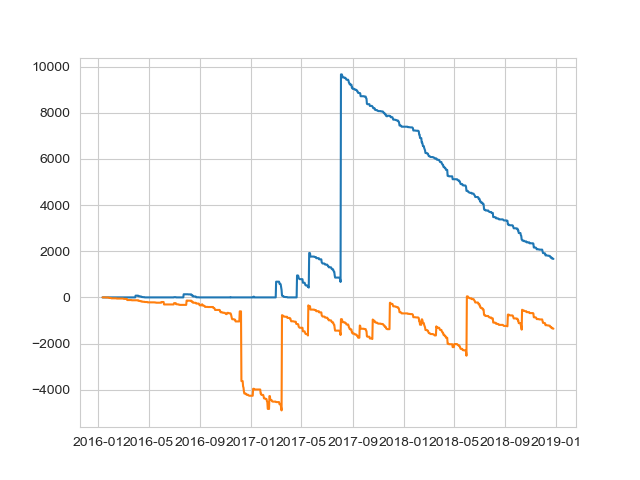

In [12]:
plt.figure()
plt.plot(df.long_storage)
plt.plot(opt_df.long_storage)

<IPython.core.display.Javascript object>


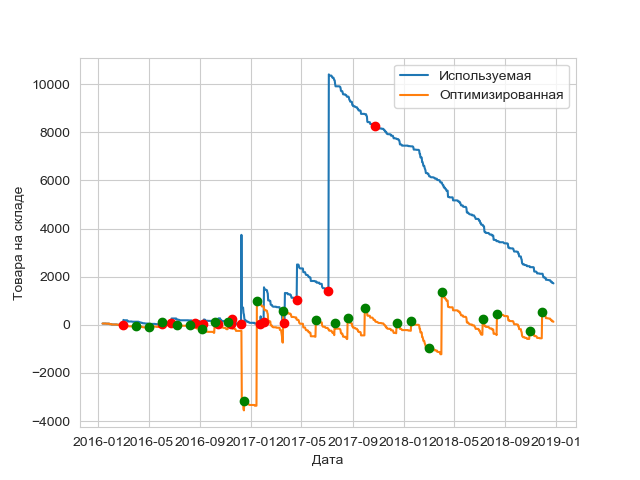

In [10]:
plt.figure()
plt.plot(df['На складе'])
plt.plot(opt_df['На складе'])
plt.plot(df[df['Приход'] > 0]['На складе'], 'ro')
plt.plot(opt_df[opt_df['Приход'] > 0]['На складе'], 'go')
plt.xlabel('Дата')
plt.ylabel('Товара на складе')
plt.legend(['Используемая', 'Оптимизированная'])

<IPython.core.display.Javascript object>


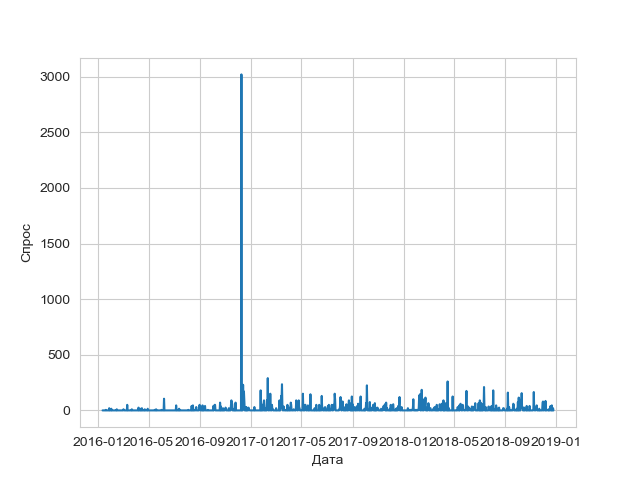

In [9]:
plt.figure()
plt.plot(df['Расход'])
plt.xlabel('Дата')
plt.ylabel('Спрос');

<IPython.core.display.Javascript object>


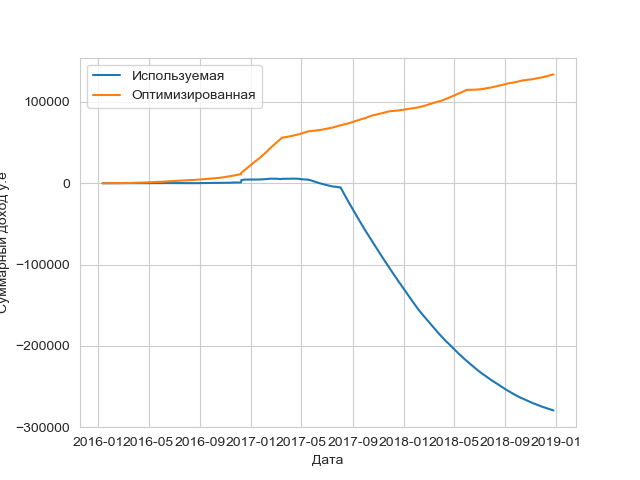

In [11]:
plt.figure()
plt.plot(df['total_profit'])
plt.plot(opt_df['total_profit'])
plt.xlabel('Дата')
plt.ylabel('Суммарный доход у.е')
plt.legend(['Используемая', 'Оптимизированная'])